# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. 

- We'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. 

- Then, we'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. 


The data that we will use has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The main deliverable for this project is a blog post that reports our findings.

To keep this work tidy and to avoid memory errors, we shall split this work into three notebooks:

Part 0: Data cleaning  
Part 1: Unsupervised Learning  
Part 2: Supervised Learning Model

In [1]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import time 

In [2]:
# Visualization imports & configuration
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20

%matplotlib inline

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [4]:
from utils import * # simple convenience functions to keep this notebook tidy

utils loaded: this module contains helpful data cleaning functions


- Load in the two Excel spreadsheets provided & have a quick look.  
- These contain information about the columns depicted in the data files which we will load next.  
- These files shall be referred to as the Excel documentation.

In [5]:
location = "data\\" # location of data files

In [6]:
# DIAS Information Levels - Attributes 2017.xlsx is a top-level list of attributes and descriptions, 
# organized by informational category. 
information_levels = pd.read_excel(location+'DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols='B:E')
print(information_levels.shape)
information_levels.head()

(313, 4)


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [7]:
#DIAS Attributes - Values 2017.xlsx is a detailed mapping of data values for each feature in alphabetical order.
attributes_values = pd.read_excel(location+'DIAS Attributes - Values 2017.xlsx', header=1, usecols='B:E')
print(attributes_values.shape)
attributes_values.head()

(2258, 4)


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


# Part 1: Data cleaning

In [8]:
location = "data\\" # location of data files

In [9]:
# load in the data files (saved previously as pickle files for faster loading)
azdias = pd.read_pickle(location+'Udacity_AZDIAS_052018.pkl')
customers = pd.read_pickle(location+'Udacity_CUSTOMERS_052018.pkl')

Loading the original csv data files gave the following error:  
`Error raised:`
`typeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.`

Inspecting columns 18 and 19 we find values X and XX mixed in with float values.
On checking the Excel documentation we find that X and XX are undocumented.

We will now convert these values to nan using the replace_symbols_with_nan() function imported from `utils`:

In [10]:
help(replace_symbols_with_nan)

Help on function replace_symbols_with_nan in module utils:

replace_symbols_with_nan(df, columns, symbols)
    For each column in the dataframe, values in the `symbols` list are replaced with nan



In [11]:
columns_to_clean = customers.columns[[18,19]]
print("These columns have mixed types and will be fixed:", columns_to_clean.values)
symbols=["XX", "X"]
customers_clean = replace_symbols_with_nan(customers, columns_to_clean, symbols)
azdias_clean = replace_symbols_with_nan(azdias, columns_to_clean, symbols)

These columns have mixed types and will be fixed: ['CAMEO_DEUG_2015' 'CAMEO_INTL_2015']


We also want to know which values in `azdias` and `customers` mean "unknown" (or "unknown / no main age detectable"). This information is in Excel documentation (`attributes_values`):

In [12]:
unknowns = attributes_values[attributes_values.Meaning.isin(["unknown / no main age detectable", "unknown"])]

We now convert this into a dictionary, so that we can use the dictionary to clean our dataframes:

In [13]:
# We now convert this into a dictionary, so that we can use the dictionary to clean our dataframes
value_of_unknown = {}
for i, row in unknowns.iterrows():
    value_of_unknown[row.Attribute] = str(row.Value).split(", ")

We will now convert unknown values using nan using the unknown_to_nan() function imported from `utils`:

In [14]:
help(unknown_to_nan)

Help on function unknown_to_nan in module utils:

unknown_to_nan(df, dict_of_unknowns)
    INPUT:
    df - pandas dataframe 
    dict_of_unknowns - key-value pairs, where values indicate "unknown" 
    
    OUTPUT:
    df - dataframe
    
    Description:
    Checks values df against dict_of_unknowns
    Return a dataframe with unknown values replaced with nan.



In [15]:
# Compare before & after:
customers_clean = unknown_to_nan(customers_clean, value_of_unknown)
print( customers.isna().sum().sum() )
print( customers_clean.isna().sum().sum() )

13864522
14487764


In [16]:
# Compare before & after:
azdias_clean = unknown_to_nan(azdias_clean, value_of_unknown)
print( azdias.isna().sum().sum() )
print( azdias_clean.isna().sum().sum() )

33492923
37073313


# Null values

We will deal now with null values in columns and rows.

In [17]:
# Columns
null_azidas_percent= 100 * azdias_clean.isnull().sum(axis=0) / (azdias_clean.shape[0])
null_azidas_percent.sort_values(ascending = False, inplace = True)
print("For each column, what percentage of the values are null?")
null_azidas_percent.head(5)

For each column, what percentage of the values are null?


ALTER_KIND4    99.864792
TITEL_KZ       99.757636
ALTER_KIND3    99.307691
ALTER_KIND2    96.690047
ALTER_KIND1    90.904837
dtype: float64

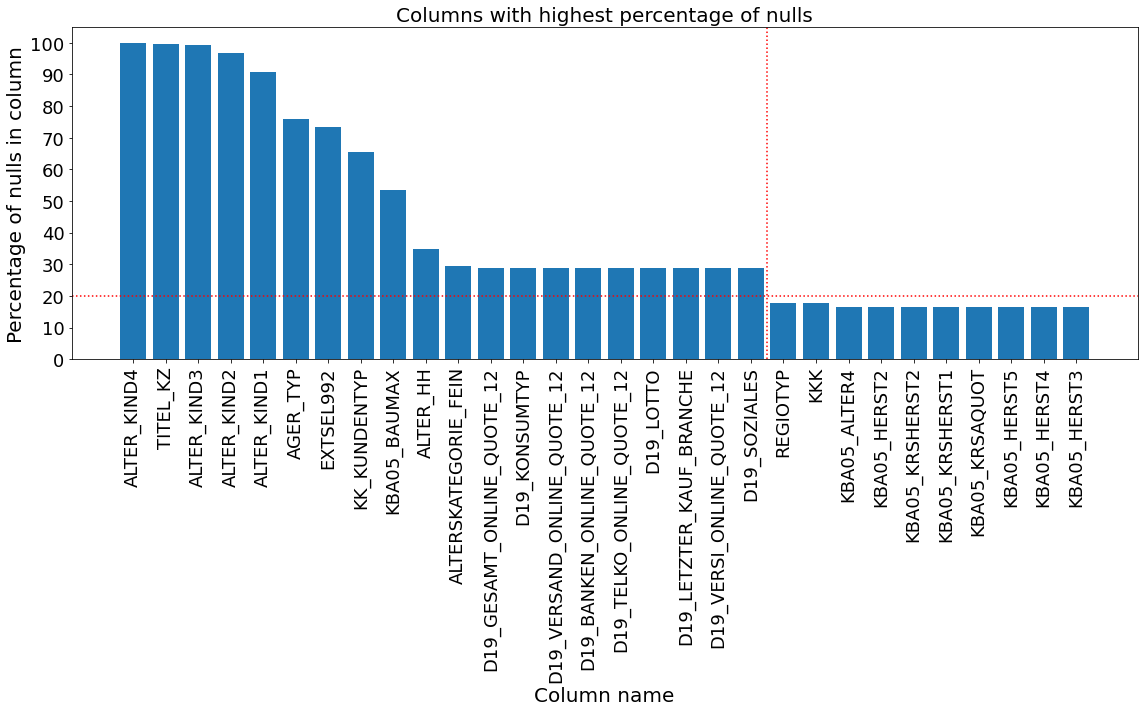

In [18]:
plt.figure(figsize = (16,10))
plt.bar(null_azidas_percent.head(30).index, null_azidas_percent.head(30))
plt.xlabel('Column name')
plt.ylabel('Percentage of nulls in column'); plt.title('Columns with highest percentage of nulls')
plt.yticks(np.arange(0,110,10))
plt.xticks(rotation = 90);
plt.axhline(20, linestyle = 'dotted', color = 'red')#; plt.axhline(30);
plt.axvline(20-0.5, linestyle = 'dotted', color = 'red');
plt.tight_layout()
plt.savefig('images/Columns with nulls.png')

In [19]:
# Determine which columns are missing more than 20% of their values
columns_missing_20_percent = null_azidas_percent[null_azidas_percent>20.0].index.tolist()
print(len(columns_missing_20_percent))
print_list(columns_missing_20_percent)

20
ALTER_KIND4, TITEL_KZ, ALTER_KIND3, ALTER_KIND2, ALTER_KIND1, AGER_TYP, EXTSEL992, KK_KUNDENTYP, KBA05_BAUMAX, ALTER_HH, ALTERSKATEGORIE_FEIN, D19_GESAMT_ONLINE_QUOTE_12, D19_KONSUMTYP, D19_VERSAND_ONLINE_QUOTE_12, D19_BANKEN_ONLINE_QUOTE_12, D19_TELKO_ONLINE_QUOTE_12, D19_LOTTO, D19_LETZTER_KAUF_BRANCHE, D19_VERSI_ONLINE_QUOTE_12, D19_SOZIALES

This agrees with the plot above (i.e., we see in both the list and the plot that the 20th element is D19_SOZIALES).

We shall remove these columns shortly.

In [20]:
# Rows
null_azidas_rows = azdias.isnull().sum(axis=1)
null_azidas_rows.sort_values(ascending = False, inplace = True)
null_azidas_rows.head()

537799    259
350182    259
55664     259
826869    259
373501    259
dtype: int64

In [21]:
# Rows
null_azidas_rows_percent= 100 * azdias_clean.isnull().sum(axis=1) / (azdias_clean.shape[1])
null_azidas_rows_percent.sort_values(ascending = False, inplace = True)
print("For each row, what percentage of the values are null?")
null_azidas_rows_percent.head(5)

For each row, what percentage of the values are null?


537799    72.131148
826869    72.131148
350182    71.857923
373501    71.857923
55664     71.857923
dtype: float64

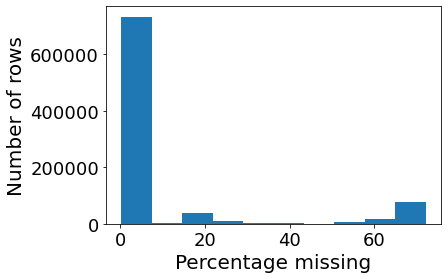

In [22]:
plt.hist(null_azidas_rows_percent);
plt.xlabel('Percentage missing');
plt.ylabel('Number of rows');

Most of the rows seem have to have less than 10% of their values missing.

In [23]:
cut_off = sum(null_azidas_rows_percent < 10) / len(null_azidas_rows_percent)
print("What percentage of rows has less than 10% null?", 100*cut_off)

What percentage of rows has less than 10% null? 82.64785053314498


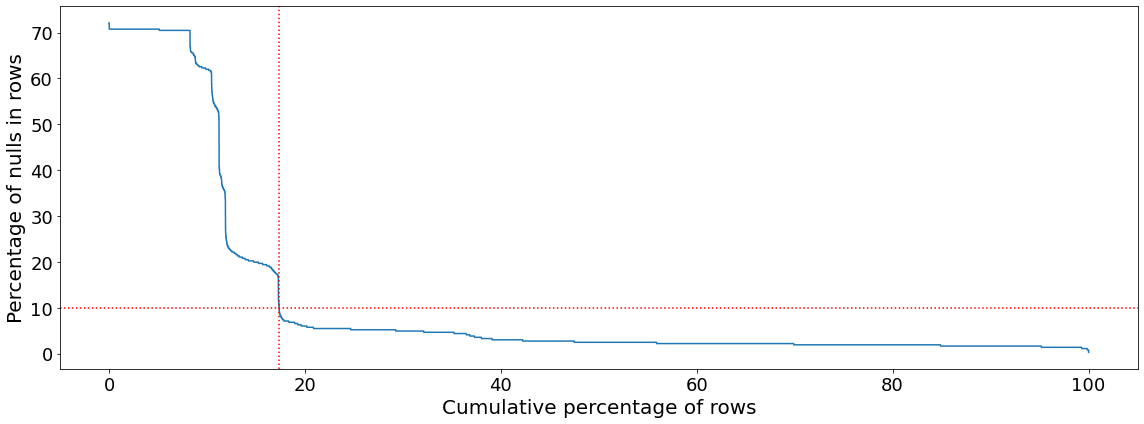

In [24]:
plt.figure(figsize = (16,6))
percent = 100
number = int(0.01*percent*azdias_clean.shape[0])
to_plot = null_azidas_rows_percent.head(number).copy()
new_index = np.arange(0, len(to_plot) )
new_index = np.linspace(0, percent, len(to_plot))
plt.plot(new_index, to_plot);
plt.xlabel('Cumulative percentage of rows'); plt.ylabel('Percentage of nulls in rows')
plt.axhline(10, linestyle = 'dotted', color = 'red');
plt.axvline(100*(1-cut_off), linestyle = 'dotted', color = 'red');
plt.tight_layout()
plt.savefig('images/Rows with nulls.png')

In [25]:
print("In other words, if we want any row to contain only a maximum of 10% null values, we need to remove {}% of the rows.".format(round(100*(1-cut_off))))

In other words, if we want any row to contain only a maximum of 10% null values, we need to remove 17% of the rows.


In [26]:
missing_values_threshold = np.floor(azdias_clean.shape[1]*0.1)
print("So we need to drop rows containing more than {} missing values.".format(missing_values_threshold))

So we need to drop rows containing more than 36.0 missing values.


We will now drop the appropriate columns and rows using the drop_columns_and_rows() function imported from `utils`:

In [27]:
help(drop_columns_and_rows)

Help on function drop_columns_and_rows in module utils:

drop_columns_and_rows(df, columns_to_drop, missing_values_threshold_row=inf)
    Drops columns from df that are in columns_to_drop.
    Drops rows where the number of missing values is above missing_values_threshold_row
    If no missing_values_threshold_row is supplied, no rows are removed.



In [28]:
azdias_clean = drop_columns_and_rows(azdias_clean, columns_missing_20_percent, missing_values_threshold)
customers_clean = drop_columns_and_rows(customers_clean,columns_missing_20_percent, missing_values_threshold)

# Categorical variables

We shall now handle categorical variables using the handle_categorical() function imported from `utils`:

In [29]:
help(handle_categorical)

Help on function handle_categorical in module utils:

handle_categorical(df_original, categories_to_handle)
    Check which columns from categories_to_handle contain non binary non-numerical values
    
    Convert these categorical variables into dummy/indicator variables. 
    New columns are created. (Original categorical variables are dropped)
    
    
    This function also drops from df_original the following undocumented columns:
    'EINGEFUEGT_AM', 'CAMEO_INTL_2015'
    This function drops D19_LETZTER_KAUF_BRANCHE because it contains too many unique values



I have manually identified the categorical variables from the Excel documentation and stored them in the categorical_variables variable.

In [30]:
categories_not_in_azdias = set(categorical_variables)-set(azdias_clean.columns)
categories_in_azdias = set(categorical_variables)-set(categories_not_in_azdias)
azdias_new  = handle_categorical(df_original=azdias_clean, categories_to_handle = categories_in_azdias)

Original columns are dropped


In [31]:
azdias_new.shape

(737287, 458)

Let us now do the same for the `customers` data frame

In [32]:
customers_clean = replace_symbols_with_nan(customers, customers.columns[[18,19]], symbols)
customers_clean = unknown_to_nan(customers_clean, value_of_unknown)
print(customers_clean.shape)
customers_clean = drop_columns_and_rows(customers_clean, columns_missing_20_percent, missing_values_threshold_row=36)
print(customers_clean.shape)
customers_new = handle_categorical(df_original=customers_clean, categories_to_handle=categories_in_azdias)

(191652, 369)
(134246, 349)
Original columns are dropped


Let us also drop the columns which are not common to azdias and customers

In [33]:
unmatched = (customers_new.columns).difference(azdias_new.columns).to_list() # Same as: set(customers.columns)-set(azdias.columns)
print("The columns to be dropped are {}".format(unmatched))
customers_new = drop_columns_and_rows(df=customers_new, columns_to_drop=unmatched, missing_values_threshold_row=np.inf)
customers_new.shape

The columns to be dropped are ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


(134246, 457)

# Imputing missing values

We shall completing missing values using the median value.

In [34]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median') 

In [35]:
print("Before imputation, number of missing values: ", azdias_new.isna().sum().sum())
azdias_new = pd.DataFrame(imp_median.fit_transform(azdias_new), columns = azdias_new.columns)
print("After imputation, number of missing values: ", azdias_new.isna().sum().sum())

Before imputation, number of missing values:  373288
After imputation, number of missing values:  0


In [36]:
print("Before imputation, number of missing values: ", customers_new.isna().sum().sum())
customers_new = pd.DataFrame(imp_median.fit_transform(customers_new), columns = customers_new.columns)
print("After imputation, number of missing values: ", customers_new.isna().sum().sum())

Before imputation, number of missing values:  95499
After imputation, number of missing values:  0


# Rescaling

To finish data wrangling, we must scale the features because we will be performing principal component analysis (PCA) next and PCA requires that the components be converted to normalized units (so that their ranges are comparable.)

In [37]:
scaling_for_pca = StandardScaler()

In [38]:
azdias_final = pd.DataFrame(scaling_for_pca.fit_transform(azdias_new), columns = azdias_new.columns)

In [39]:
customers_final = pd.DataFrame(scaling_for_pca.fit_transform(customers_new), columns = customers_new.columns)

In [40]:
azdias_final.to_pickle('data/azdias_final.pkl')

In [41]:
customers_final.to_pickle('data/customers_final.pkl')